In [1]:
!pip install pytorch-tabnet wget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 787.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=99eb5f871ba913b26cb1affa4f99e5bfb56d80a9d4a492ac26761c3c1fdb23e8
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path
import shutil
import gzip

from matplotlib import pyplot as plt
%matplotlib inline

# Download ForestCoverType dataset

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
dataset_name = 'forest-cover-type'
tmp_out = Path('./data/'+dataset_name+'.gz')
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [4]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, tmp_out.as_posix())
    with gzip.open(tmp_out, 'rb') as f_in:
        with open(out, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)



# Load data and split
Same split as in original paper

In [5]:
target = "Covertype"

bool_columns = [
    "Wilderness_Area1", "Wilderness_Area2", "Wilderness_Area3",
    "Wilderness_Area4", "Soil_Type1", "Soil_Type2", "Soil_Type3", "Soil_Type4",
    "Soil_Type5", "Soil_Type6", "Soil_Type7", "Soil_Type8", "Soil_Type9",
    "Soil_Type10", "Soil_Type11", "Soil_Type12", "Soil_Type13", "Soil_Type14",
    "Soil_Type15", "Soil_Type16", "Soil_Type17", "Soil_Type18", "Soil_Type19",
    "Soil_Type20", "Soil_Type21", "Soil_Type22", "Soil_Type23", "Soil_Type24",
    "Soil_Type25", "Soil_Type26", "Soil_Type27", "Soil_Type28", "Soil_Type29",
    "Soil_Type30", "Soil_Type31", "Soil_Type32", "Soil_Type33", "Soil_Type34",
    "Soil_Type35", "Soil_Type36", "Soil_Type37", "Soil_Type38", "Soil_Type39",
    "Soil_Type40"
]

int_columns = [
    "Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]

feature_columns = (
    int_columns + bool_columns + [target])


In [6]:
train = pd.read_csv(out, header=None, names=feature_columns)

n_total = len(train)

# Train, val and test split follows
# Rory Mitchell, Andrey Adinets, Thejaswi Rao, and Eibe Frank.
# Xgboost: Scalable GPU accelerated learning. arXiv:1806.11248, 2018.

train_val_indices, test_indices = train_test_split(
    range(n_total), test_size=0.2, random_state=0)
train_indices, valid_indices = train_test_split(
    train_val_indices, test_size=0.2 / 0.6, random_state=0)


# Simple preprocessing

Label encode categorical features and fill empty cells.

In [7]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

# Define categorical features for categorical embeddings

In [8]:
# This is a generic pipeline but actually no categorical features are available for this dataset

unused_feat = []

features = [ col for col in train.columns if col not in unused_feat+[target]]

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]


# Network parameters

In [9]:
clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


# Training

In [10]:
if os.getenv("CI", False):
# Take only a subsample to run CI
    X_train = train[features].values[train_indices][:1000,:]
    y_train = train[target].values[train_indices][:1000]
else:
    X_train = train[features].values[train_indices]
    y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [11]:
max_epochs = 100 if not os.getenv("CI", False) else 2

In [12]:
from pytorch_tabnet.augmentations import ClassificationSMOTE
aug = ClassificationSMOTE(p=0.2)

# clf.fit(
#     X_train=X_train, y_train=y_train,
#     eval_set=[(X_train, y_train), (X_valid, y_valid)],
#     eval_name=['train', 'valid'],
#     max_epochs=max_epochs, patience=100,
#     batch_size=16384, virtual_batch_size=256,
#     augmentations=aug
# )

In [13]:
# # plot losses
# plt.plot(clf.history['loss'])

In [14]:
# # plot accuracy
# plt.plot(clf.history['train_accuracy'])
# plt.plot(clf.history['valid_accuracy'])

### Predictions


In [15]:
# # To get final results you may need to use a mapping for classes
# # as you are allowed to use targets like ["yes", "no", "maybe", "I don't know"]

# preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}

# preds = clf.predict_proba(X_test)

# y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))

# test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)

# print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
# print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

In [17]:
# # or you can simply use the predict method

# y_pred = clf.predict(X_test)
# test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
# print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

# Save and load Model

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
# # save state dict
# saved_filename = clf.save_model('/content/drive/My Drive/test_model')


In [20]:
# define new model and load save parameters
loaded_clf = TabNetClassifier()
loaded_clf.load_model('/content/drive/My Drive/test_model.zip')

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [21]:
loaded_preds = loaded_clf.predict_proba(X_test)
# loaded_y_pred = np.vectorize(preds_mapper.get)(np.argmax(loaded_preds, axis=1))

# loaded_test_acc = accuracy_score(y_pred=loaded_y_pred, y_true=y_test)

# print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_acc}")

In [22]:
# assert(test_acc == loaded_test_acc)

In [39]:
median_vals = torch.Tensor(np.median(X_train, 0)).to(loaded_clf.device)
median_vals

tensor([2996.,  127.,   13.,  218.,   29., 1998.,  218.,  226.,  143., 1708.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.], device='cuda:0')

In [117]:
from pytorch_tabnet.utils import PredictDataset
from torch.utils.data import DataLoader

dataloader = DataLoader(
    PredictDataset(X_test),
    batch_size=1,
    shuffle=True,
)

In [118]:
loaded_clf.device

device(type='cuda')

In [119]:
loaded_clf.network

TabNet(
  (embedder): EmbeddingGenerator()
  (tabnet): TabNetNoEmbeddings(
    (initial_bn): BatchNorm1d(54, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (encoder): TabNetEncoder(
      (initial_bn): BatchNorm1d(54, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (initial_splitter): FeatTransformer(
        (shared): GLU_Block(
          (shared_layers): ModuleList(
            (0): Linear(in_features=54, out_features=256, bias=False)
            (1): Linear(in_features=128, out_features=256, bias=False)
          )
          (glu_layers): ModuleList(
            (0): GLU_Layer(
              (fc): Linear(in_features=54, out_features=256, bias=False)
              (bn): GBN(
                (bn): BatchNorm1d(256, eps=1e-05, momentum=0.3, affine=True, track_running_stats=True)
              )
            )
            (1): GLU_Layer(
              (fc): Linear(in_features=128, out_features=256, bias=False)
              (bn): GBN(
         

In [120]:
softmax = torch.nn.Softmax(dim=1).to(loaded_clf.device)

In [121]:
def classifier(data, target):
    data.requires_grad = True
    output, _ = loaded_clf.network(data)
    predictions = softmax(output)
    return predictions[0, target]

all_stats, all_p1, all_p2 = [], [], []
# 0 - Pos, 1 - Neg
# 0 - ori, 1 - wtd
# 0 - t1, 1 - t2

cnt = 0
for _, data in enumerate(dataloader):
    with torch.set_grad_enabled(True):
        data = data.to(loaded_clf.device).float()
        output, _ = loaded_clf.network(data)
        predictions = softmax(output)
        t1, t2 = predictions.argsort(1, descending=True)[0, :2]
        p1, p2 = predictions[0, [t1, t2]]
        if p2 > 0.1:
            cnt += 1
            grad1, = torch.autograd.grad(classifier(data, t1), data, torch.tensor(1.))
            loaded_clf.network.zero_grad(set_to_none=True)
            relevance1 = data.detach() * grad1.detach()

            grad2, = torch.autograd.grad(classifier(data, t2), data, torch.tensor(1.))
            loaded_clf.network.zero_grad(set_to_none=True)
            relevance2 = data.detach() * grad2.detach()

            grads = [data.detach() * torch.autograd.grad(classifier(data, c), data, torch.tensor(1.))[0].detach() for c in range(output.shape[1])]
            loaded_clf.network.zero_grad(set_to_none=True)
            relevances = torch.cat(grads)
            relevance1_w = relevance1 - predictions @ relevances
            relevance2_w = relevance2 - predictions @ relevances

            relevances_dict = {
                'original': {
                    't1': relevance1,
                    't2': relevance2
                },
                'weighted': {
                    't1': relevance1_w,
                    't2': relevance2_w
                }
            }

            all_p1.append(p1 / (p1 + p2))
            all_p2.append(p2 / (p1 + p2))
            stats = np.zeros((2, 2, 2))

            for i, contrast in enumerate(['original', 'weighted']):
                for j, target_str in enumerate(['t1', 't2']):
                    mask = (relevances_dict[contrast][target_str].flatten() < 0).to(loaded_clf.device)
                    data1 = data.detach()
                    data1[:, mask] = median_vals[mask]
                    output1, _ = loaded_clf.network(data1)
                    predictions1 = softmax(output1)
                    p11, p21 = predictions1[0, [t1, t2]]
                    stats[0][i][j] = (p21 if j else p11) / (p11 + p21)

                    mask = (relevances_dict[contrast][target_str].flatten() > 0).to(loaded_clf.device)
                    data2 = data.detach()
                    data2[:, mask] = median_vals[mask]
                    output2, _ = loaded_clf.network(data2)
                    predictions2 = softmax(output2)
                    p12, p22 = predictions2[0, [t1, t2]]
                    stats[1][i][j] = (p22 if j else p12) / (p12 + p22)
            all_stats.append(stats)
            if cnt >= 300:
                break

In [105]:
all_p1, all_p2

([tensor(0.8047, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.6623, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.5371, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.6190, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.7256, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.7477, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.5303, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.6230, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.6488, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.6382, device='cuda:0', grad_fn=<DivBackward0>)],
 [tensor(0.1953, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.3377, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.4629, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.3810, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.2744, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.2523, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(0.4697, device='cuda:0', grad_fn=<DivBackward0

In [122]:
a = np.stack(all_stats)
print(a.shape)
mean, std = a.mean(0), a.std(0)

(300, 2, 2, 2)


In [123]:
a[:10]

array([[[[4.30005848e-01, 4.44960654e-01],
         [5.55039287e-01, 4.44960654e-01]],

        [[5.55039287e-01, 4.44960654e-01],
         [5.55039287e-01, 4.44960654e-01]]],


       [[[9.53274608e-01, 5.55039287e-01],
         [4.44960654e-01, 5.55039287e-01]],

        [[4.44960654e-01, 5.55039287e-01],
         [4.44960654e-01, 5.55039287e-01]]],


       [[[9.33134556e-01, 4.44960654e-01],
         [5.55039287e-01, 4.44960654e-01]],

        [[5.55039287e-01, 4.44960654e-01],
         [5.55039287e-01, 4.44960654e-01]]],


       [[[4.73886460e-01, 7.52662420e-01],
         [2.47337595e-01, 7.52662420e-01]],

        [[2.47337595e-01, 7.52662420e-01],
         [2.47337595e-01, 7.52662420e-01]]],


       [[[5.69327593e-01, 4.44960654e-01],
         [5.55039287e-01, 4.44960654e-01]],

        [[5.55039287e-01, 4.44960654e-01],
         [5.55039287e-01, 4.44960654e-01]]],


       [[[2.13038832e-01, 7.23165087e-03],
         [9.92768347e-01, 7.23165087e-03]],

        [[9.92768347e-

In [124]:
sum(all_p1) / cnt, sum(all_p2) / cnt

(tensor(0.7368, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.2632, device='cuda:0', grad_fn=<DivBackward0>))

In [125]:
result = np.zeros((2, 4))

for i1 in range(2):
    for i2 in range(2):
        for i3 in range(2):
            result[i3][2 * i1 + i2] = mean[i1][i2][i3]

print(*result.tolist(), sep='\n')

[0.5647704126092382, 0.5151011993075372, 0.5151011993075372, 0.5151011993075372]
[0.48489876495392914, 0.48489876495392914, 0.48489876495392914, 0.48489876495392914]


# Global explainability : feat importance summing to 1

In [ ]:
clf.feature_importances_

array([1.58247662e-01, 5.71626673e-04, 9.29850777e-03, 5.07113137e-02,
       7.62325992e-03, 1.06987014e-01, 1.15743237e-02, 3.18730107e-02,
       6.96937310e-03, 8.35709639e-03, 4.90208937e-02, 3.14086266e-04,
       9.01340430e-03, 2.38246169e-02, 3.95427641e-04, 5.54882820e-02,
       1.12409596e-02, 1.27723175e-02, 6.84919206e-03, 3.50048954e-03,
       3.61859762e-02, 6.51597059e-03, 1.86473636e-03, 6.41088076e-06,
       1.40285334e-02, 8.26091070e-02, 3.95778852e-02, 1.09173924e-02,
       1.34896714e-03, 2.96117212e-02, 6.22127663e-07, 7.14214126e-03,
       9.28666417e-03, 7.99605141e-04, 6.81673364e-03, 3.18115593e-02,
       1.23340882e-04, 7.97161799e-03, 9.67607270e-04, 3.66789348e-03,
       2.70878094e-03, 1.80842013e-02, 1.69281652e-02, 9.58653523e-03,
       6.89841920e-03, 1.97940973e-02, 6.74800837e-03, 8.98283106e-03,
       5.30832858e-03, 4.21483625e-03, 2.12773169e-03, 2.50390367e-02,
       1.24629806e-02, 5.22870434e-03])

# Local explainability and masks

In [ ]:
explain_matrix, masks = clf.explain(X_test)

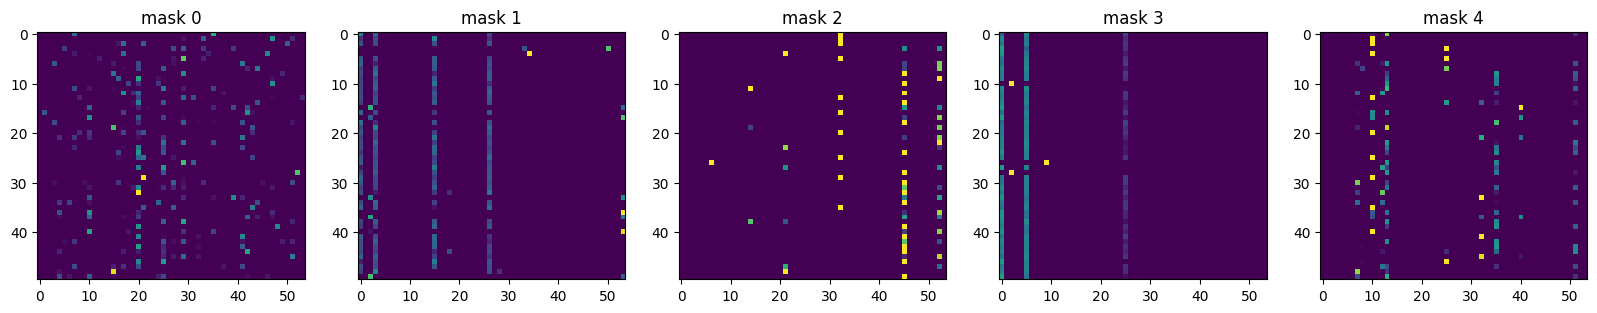

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(20,20))

for i in range(5):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

# XGB

In [ ]:
n_estimators = 1000 if not os.getenv("CI", False) else 20

In [ ]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=n_estimators,
    verbosity=0,
    silent=None,
    objective="multi:softmax",
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            early_stopping_rounds=40,
            verbose=10)

In [ ]:
preds_valid = np.array(clf_xgb.predict_proba(X_valid, ))
valid_acc = accuracy_score(y_pred=np.argmax(preds_valid, axis=1) + 1, y_true=y_valid)
print(valid_acc)

preds_test = np.array(clf_xgb.predict_proba(X_test))
test_acc = accuracy_score(y_pred=np.argmax(preds_test, axis=1) + 1, y_true=y_test)
print(test_acc)